**Пути к директориям и файлам**

In [306]:
TRAIN_DATASET_PATH = '../../project_task/train.csv' # y_train, y_valid
TEST_DATASET_PATH = '../../project_task/test.csv'
PREDICTIONS_PATH = '../../project_task/AZakharenkov_predictions.csv'

### Подключение библиотек и скриптов

In [307]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Функция оценки метрики качества прогнозирования

In [308]:
def evaluate_preds(train_true_values, train_pred_values, valid_true_values, valid_pred_values):
    """
    Функция принимает 4 массива для оценки качества предсказания:
      - столбец истинных значений целевой переменной обучающей выборки
      - столбец предсказаний целевой переменной обучающей выборки
      - столбец истинных значений целевой переменной валидационной выборки
      - столбец предсказаний целевой переменной валидационной выборки
      
    Функция выводит метрику качества R2 для двух наборов и 
    диаграммы для визуального сравнения качества предсказания.
    """
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(valid_true_values, valid_pred_values), 3)))

    plt.figure(figsize=(18,10))
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=valid_pred_values, y=valid_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Validation sample prediction')

    plt.show()

### Загрузка данных

**Описание датасета**

* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры

In [309]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9995,77,32,2.0,50.401785,30.476203,5.0,6,5.0,1968,0.135650,B,B,46,7960,6,350.0,3,11,B,196684.316040
9996,6159,18,1.0,41.521546,20.539216,9.0,13,13.0,2000,0.000000,B,B,30,5562,0,NaN,0,5,A,189050.289571
9997,5123,27,1.0,47.939008,NaN,1.0,12,16.0,2015,0.072158,B,B,2,629,1,NaN,0,0,A,159143.805370
9998,5400,75,2.0,43.602562,33.840147,8.0,1,5.0,1961,0.307467,B,A,30,5048,9,325.0,2,5,B,181595.339808
9999,6306,128,1.0,38.666645,21.157874,8.0,7,17.0,1990,0.000000,B,B,27,4798,0,30.0,2,8,B,218714.077615


## Построение новых признаков

На этапе исследования пробовал построить признак *IsDistrictLarge*, он показал малую важность <code>feature_importances_</code>, а также *MedRoomPriceByDistrict* - средняя стоимость комнаты по району - он показал гораздо большю важность. Так как объём данных и сложность модели позволяла, не стал исключать малозначительные признаки из конечной модели.

## Предобработка данных

делается методом класса <code>DataPreparator.prepare_data()</code>, содержащим подробные комментарии.

In [310]:
class DataPreparator:
    """Класс делает предварительную обработку данных. Применяется сначала
    к обучающей, потом к тестовой выборке. Будучи применён к обучающей
    выборке, он сохраняет данные, необходимые для дополнения тестовой выборки -
    именно параметр "средняя цена комнаты по району".
    """
    
    def __convert_pseudo_number_features_to_str(self):
        """Числовые колонки, которые не являются численными
        показателями, преобразуем в строковые
        """
        self.df['Id'] = self.df['Id'].astype(str)
        self.df['DistrictId'] = self.df['DistrictId'].astype(str)
    
    def __process_outliers(self, is_train):
        """Замена и выкидывание выбросов"""
        
        if is_train:
            # Ненормальные значения кол-ва комнат заменяем на медиану
            self.df.loc[self.df['Rooms'].isin([0, 10, 19]), 'Rooms'] = self.df['Rooms'].median()

            # Устанавливаем более реалистичные значения жилой площади и площади кухни
            self.df.loc[self.df['LifeSquare'] < 10, 'LifeSquare'] = 10
            self.df.loc[self.df['KitchenSquare'] < 4, 'KitchenSquare'] = 4

            # Выбрасываем строки с хвостами по площади (всего около 10 строк из 10000)
            for feature in ('Square', 'LifeSquare', 'KitchenSquare'):
                self.df = self.df[
                    self.df[feature].isnull() |
                    (self.df[feature] < self.df[feature].quantile(.99)) &
                    (self.df[feature] > self.df[feature].quantile(.01))
                ]

    def __correct_inconsistencies(self, is_train):
        
        # Этажность дома не может быть 0
        self.df.loc[self.df['HouseFloor'] == 0, 'HouseFloor'] = self.df['HouseFloor'].median()
        
        # В тренировочных данных некорректностей, где этаж квартиры выше дома, было 1825
        floor_outliers = self.df[self.df['Floor'] > self.df['HouseFloor']].index
        
        if is_train:
            np.random.seed(23)
            self.df.loc[floor_outliers, 'Floor'] = self.df.loc[floor_outliers, 'HouseFloor'].apply(
            lambda x: random.randint(1, x))
        else:
            self.df.loc[floor_outliers, 'Floor'] = self.df.loc[floor_outliers, 'HouseFloor']
            
        self.df.loc[self.df['HouseYear'] > 2020, 'HouseYear'] = 2020
    
    def __fill_NaNs(self):
        
        # Столбец LifeSquare содержит NaN-ы. Заменим их исходя из остальных площадей
        square_med_diff = (self.df.loc[self.df['LifeSquare'].notnull(), 'Square'] -
                   self.df.loc[self.df['LifeSquare'].notnull(), 'LifeSquare'] -
                   self.df.loc[self.df['LifeSquare'].notnull(), 'KitchenSquare']).median()
        
        self.df.loc[self.df['LifeSquare'].isnull(), 'LifeSquare'] = (
            self.df.loc[self.df['LifeSquare'].isnull(), 'Square'] -
            self.df.loc[self.df['LifeSquare'].isnull(), 'KitchenSquare'] -
            square_med_diff
        )
        
        self.df.loc[self.df['Healthcare_1'].isnull(), 'Healthcare_1'] = self.df['Healthcare_1'].median()
          
    def __construct_new_features(self, is_train):
        
        # Получение бинарных признаков из категориальных с двумя значениями
        self.df['Ecology_2_bin'] = self.df['Ecology_2'].replace({'A':0, 'B':1})
        self.df['Ecology_3_bin'] = self.df['Ecology_3'].replace({'A':0, 'B':1})
        self.df['Shops_2_bin'] = self.df['Shops_2'].replace({'A':0, 'B':1})
        
        # Размер района вместо номера
        district_size = self.df['DistrictId'].value_counts().reset_index()\
               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
        self.df = self.df.merge(district_size, on='DistrictId', how='left')
        self.df['IsDistrictLarge'] = (self.df['DistrictSize'] > 100).astype(int)
        
        # Медианная цена комнаты по району
        if is_train:
            # На этапе обучения сохраняем вычисленный признак для районов
            self.df['RoomPrice'] = self.df['Price'] / self.df['Rooms']

            self.med_room_price_by_district = self.df.groupby(['DistrictId'], as_index=False).agg({'RoomPrice':'median'})\
                                   .rename(columns={'RoomPrice':'MedRoomPriceByDistrict'})
            self.med_room_price = self.med_room_price_by_district['MedRoomPriceByDistrict'].median()
        
        assert hasattr(self, 'med_room_price_by_district'), \
            "Нужно вызвать prepare_data() сначала для тренировочной выборки"
        
        self.df = self.df.merge(self.med_room_price_by_district, on=['DistrictId'], how='left')
        self.df.loc[self.df['MedRoomPriceByDistrict'].isnull(), 'MedRoomPriceByDistrict'] = self.med_room_price
        
    def prepare_data(self, df, is_train):
        """Подготовка данных. Тренировочные данные можно удалять и сглаживать по своему усмотрению,
        в данные для предсказания можно вносить только необходимые изменения для консистентности
        и переносить признаки, вычисленные во время обучения.
        """
        self.df = df
        
        self.__convert_pseudo_number_features_to_str()
        
        self.__process_outliers(is_train)
            
        self.__correct_inconsistencies(is_train)
        
        self.__fill_NaNs()
        
        self.__construct_new_features(is_train)
        
        return self.df
        


**Этот экземпляр DataPreparator нужен как при обработке обучающих, так и тестовых данных**

In [311]:
data_preparator = DataPreparator()

prepared_train_df = data_preparator.prepare_data(train_df, is_train=True)

In [312]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 
                 'Ecology_2_bin', 'Ecology_3_bin',
                 'Social_1', 'Social_2', 'Social_3',
                 'Healthcare_1', 'Helthcare_2', 'Shops_1',
                 'Shops_2_bin',
                 'IsDistrictLarge',
                 'MedRoomPriceByDistrict'
]

target_name = 'Price'

## Настройка модели с помощью GridSearch

In [313]:
def train_model_gs(train_df):
    
    # На этапе тьюнинга модели массивы параметров были больше
    parameters = {
        'n_estimators': [250, 300, 400],
        'max_features': ['auto', 10, 11],
        'max_depth': np.arange(10, 13),
    }

    gs_regressor = GridSearchCV(
        estimator=RandomForestRegressor(min_samples_split=100,
                                        n_jobs=-1,
                                        random_state=24),
        param_grid=parameters,
        scoring='r2',
        cv=5,
    )

    X = train_df[feature_names]
    y = train_df[target_name]
    
    X_train, X_valid, y_train, y_valid = train_test_split(
        X, y, test_size=0.33, shuffle=True, random_state=23
    )

    gs_regressor.fit(X_train, y_train)

    y_train_preds = gs_regressor.predict(X_train)
    y_valid_preds = gs_regressor.predict(X_valid)

    evaluate_preds(y_train, y_train_preds, y_valid, y_valid_preds)
    
    return gs_regressor

Train R2:	0.706
Test R2:	0.674


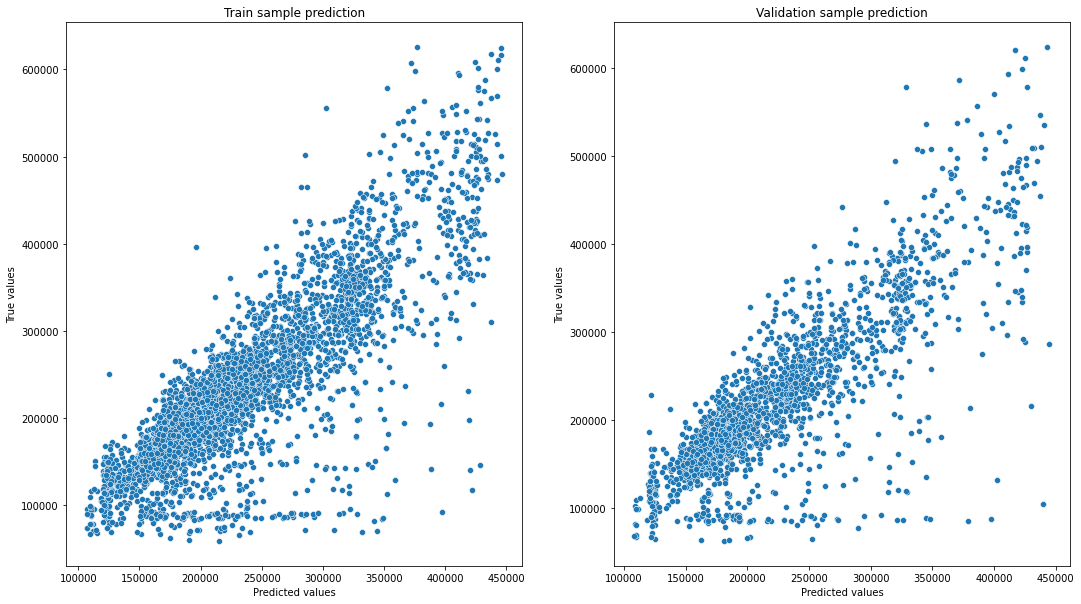

In [314]:
gs_regressor = train_model_gs(prepared_train_df)


#### Посмотрим, что на нашей сетке параметров качество не сильно отличается,
значит сильно лучших результатов не достичь. Увеличение глубины может привести к переобучению.

In [315]:
cv_results = pd.DataFrame(gs_regressor.cv_results_)

cv_results.columns

param_columns = [
    column
    for column in cv_results.columns
    if column.startswith('param_')
]

score_columns = ['mean_test_score']

cv_results = (cv_results[param_columns + score_columns]
              .sort_values(by=score_columns, ascending=False))

cv_results.head(6)

,param_max_depth,param_max_features,param_n_estimators,mean_test_score
12,11,10,250,0.642113
13,11,10,300,0.641988
15,11,11,250,0.641648
22,12,10,300,0.641515
21,12,10,250,0.641498
16,11,11,300,0.641401


In [316]:
gs_regressor.best_params_

{'max_depth': 11, 'max_features': 10, 'n_estimators': 250}

## Конечная модель

In [317]:
model = gs_regressor.best_estimator_
model

RandomForestRegressor(max_depth=11, max_features=10, min_samples_split=100,
                      n_estimators=250, n_jobs=-1, random_state=24)

### Важность признаков

In [318]:
feature_importances = pd.DataFrame(zip(feature_names, model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
1,Square,0.453395
18,MedRoomPriceByDistrict,0.147464
2,LifeSquare,0.112990
0,Rooms,0.097829
11,Social_2,0.046332
12,Social_3,0.043928
10,Social_1,0.034508
3,KitchenSquare,0.012991
6,HouseYear,0.012872
7,Ecology_1,0.009636


## Формирование файла с прогнозами

In [319]:
test_df = pd.read_csv(TEST_DATASET_PATH)

p_test_df = data_preparator.prepare_data(test_df, is_train=False)

y_test_preds = model.predict(p_test_df[feature_names])

pred_df = pd.DataFrame({'Id': test_df["Id"],
                        'Price': y_test_preds})
assert pred_df.shape[0] == 5000, f"Real pred-shape = {pred_df.shape[0]}, Expected pred-shape = 5000"

pred_df.to_csv(PREDICTIONS_PATH, index=False)